# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
# nltk
%pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns

nltk.download(['punkt', 'punkt_tab','wordnet', 'stopwords','averaged_perceptron_tagger'])




df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)

del df['Unnamed: 0']

df.head()

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/shelter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/shelter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /Users/shelter/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shelter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shelter/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [5]:
# Some interactions do not have a user associated with it, assume the same user.
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [6]:
print(f"Number of Null email values is: " , df.email.isna().sum())

Number of Null email values is:  17


In [7]:
df[df.email.isna()]


,article_id,title,email
25131,1016,why you should master r (even if it might even...,NaN
29758,1393,the nurse assignment problem,NaN
29759,20,working interactively with rstudio and noteboo...,NaN
29760,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,62,data visualization: the importance of excludin...,NaN
35264,224,"using apply, sapply, lapply in r",NaN
35276,961,beyond parallelize and collect,NaN
35277,268,sector correlations shiny app,NaN
35278,268,sector correlations shiny app,NaN
35279,268,sector correlations shiny app,NaN


In [8]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')


In [9]:
# Check if no more NaNs 
df[df.email.isna()]

,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

Descriptive Statistics of Articles Interacted With:
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


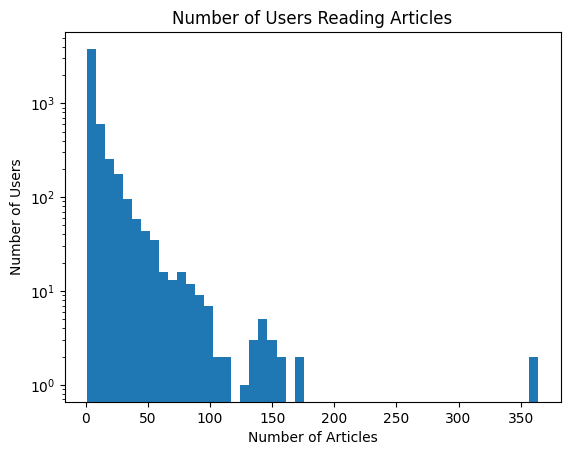

In [10]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].count()

# Compute descriptive statistics
stats = user_article_counts.describe()

print("Descriptive Statistics of Articles Interacted With:")
print(stats)

plt.hist(user_article_counts, bins=50, log=True)
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users')
plt.title('Number of Users Reading Articles')
plt.show()

/var/folders/5q/9g2nhgj11gqbp3ylkxghhgz80000gn/T/ipykernel_51036/638390704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_article_counts[:15].values, y=user_article_counts[:15].index.str[-5:], palette="viridis")


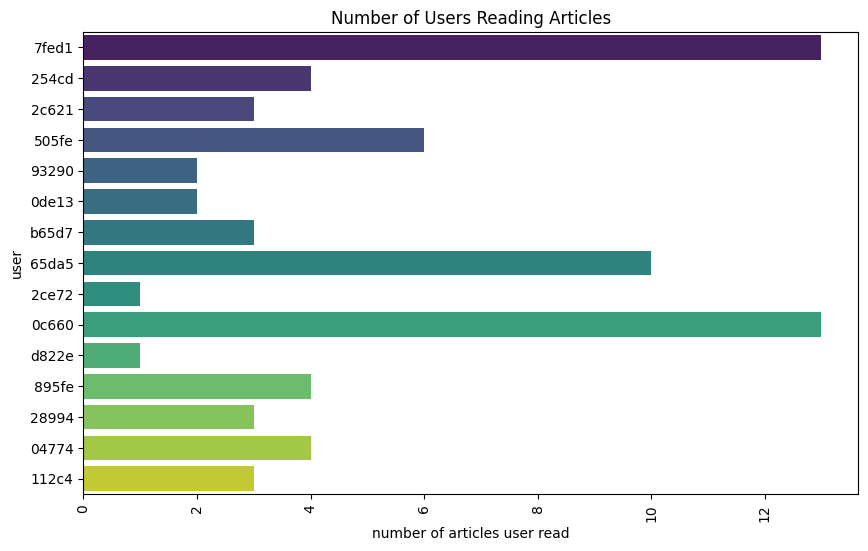

In [11]:
import seaborn as sns
# Create a plot of the number of articles read by each user

# Group by user_id to calculate the number of articles interacted with by each user
user_article_counts = df.groupby('email')['article_id'].count()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=user_article_counts[:15].values, y=user_article_counts[:15].index.str[-5:], palette="viridis")

plt.xlabel('number of articles user read')
plt.ylabel('user')
plt.title('Number of Users Reading Articles')
plt.xticks(rotation=90)

plt.show()


/var/folders/5q/9g2nhgj11gqbp3ylkxghhgz80000gn/T/ipykernel_51036/2358342102.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=article_read_counts[:30].index, y=article_read_counts[:30].values, palette="mako")


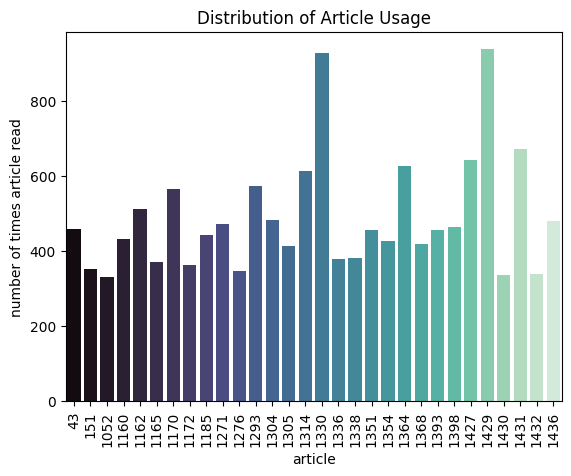

In [12]:
# Create a plot of the number of times each article was read

# Calculate the count of each article being read
article_read_counts = df['article_id'].value_counts()
sns.barplot(x=article_read_counts[:30].index, y=article_read_counts[:30].values, palette="mako")

plt.xlabel('article')
plt.ylabel('number of times article read')
plt.title('Distribution of Article Usage')
plt.xticks(rotation=90)

plt.show()

In [13]:
# Fill in the median and maximum number of user_article interactions below
user_interaction = df.email.value_counts(dropna=False)

most_articles = df.article_id.value_counts(dropna=False)

cum_user = np.cumsum(most_articles.values)

median_val = len(cum_user[cum_user <= len(user_interaction)/2]) # 50% of individuals interact with ____ number of articles or fewer.

max_views_by_user = user_interaction.iloc[0]  # The maximum number of user-article interactions by any 1 user is ______.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:

unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df.article_id.unique()) # The number of unique articles on the IBM platform
unique_users = len(user_interaction) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions



`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
# Calculate the most viewed article
most_viewed_article_id = df['article_id'].value_counts().idxmax()  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?
max_views

np.int64(937)

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
df1 = df.drop('email', axis=1)

# show header
df1.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [25]:
def get_top_articles(n, df=df1):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """

    top_articles = df[df['article_id'].isin(get_top_article_ids(n))]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df1):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    article_read_counts = df['article_id'].value_counts()
    
    top_article_ids = article_read_counts.head(n).index.tolist()
 
    return top_article_ids # Return the top article ids

In [26]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [27]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [28]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    
    # Create the user-item matrix using pivot_table
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=fill_value)
    user_item[user_item > 0] = 1
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df1)
user_item

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # compute similarity of each user to the provided user
    similarity_matrix = user_item.dot(user_item.loc[user_id])

    # user_vector = user_item.loc[user_id].values
    
    # similarities = user_item.apply(lambda x: np.dot(x.values, user_vector), axis=1)

    # sort by similarity
    sorted_similarities = similarity_matrix.sort_values(ascending=False)
    
    # remove the own user's id
    sorted_similarities = sorted_similarities.drop(user_id)
    
    if include_similarity:
        most_similar_users = [[user, int(similarity)] for user, similarity in zip(sorted_similarities.index, sorted_similarities.values)]
    else:
        most_similar_users = sorted_similarities.index.tolist()

        
    return most_similar_users  # return a list of the users in order from most to least similar
        

In [32]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))


The 10 most similar users to user 1 are: [3933, 23, 3782, 4459, 203, 131, 3870, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [33]:
def get_article_names(article_ids, df=df1):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Your code here
    # article_ids = [int(x) for x in article_ids]
    
    # df_copy = df.drop_duplicates(subset=['article_id'])
    
    # df_copy.set_index('article_id', inplace=True)
    
    # article_names = list(df_copy.loc[article_ids]['title'])

    articles_names = []
    for i in article_ids:
        art_name = df[df['article_id'] == int(i)]['title'].iloc[0]
        articles_names.append(art_name)
    
    return articles_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Your code here
    
    article_counts = user_item[article_ids].sum(axis=0)
        
    ranked_article_counts = sorted(article_counts.items(), key=lambda x: int(x[1]), reverse=True)

    ranked_article_counts = [[int(x[0]), int(x[1])] for x in ranked_article_counts]

    return ranked_article_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    items = user_item.loc[user_id]
   
    article_ids = list(items[items == 1].index)
    
    article_ids = [int(x) for x in article_ids]
    
    article_names = get_article_names(article_ids)
        
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Your code here
    article_ids, _ = get_user_articles(user_id)
    
    similarity_scores = find_similar_users(user_id)
        
    recs = []
    
    for sim_user in similarity_scores:
        # Find articles that the current similar user has interacted with, but the input user hasn't
        ids, _ = get_user_articles(sim_user)
        
        unseen_articles = np.setdiff1d(np.array(ids), np.array(article_ids), assume_unique=True)
        
        recs = np.unique(np.concatenate([recs, unseen_articles], axis=0)).tolist()
                        
        # Stop if we have collected 'm' recommendations
        if len(recs) > m -1:
            break
    
    recs = recs[:m]
            
    return recs # return your recommendations for this user_id    

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [35]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
import numpy as np
import pandas as pd

def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Description:
    Returns a sorted dataframe of users who are most similar to the given user_id, sorted by similarity and the number of interactions.
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Get the user vector for the given user_id
    user_vector = user_item.loc[user_id].values.reshape(1, -1)
    
    # Drop the user from the user-item matrix to avoid self-comparison
    other_users = user_item.drop(user_id)
    
    # Calculate cosine similarity between the user and all other users
    similarities = cosine_similarity(user_vector, other_users.values).flatten()
    
    # Create a DataFrame with similarity scores
    df_similarity = pd.DataFrame({
        'neighbor_id': other_users.index,  # Use the index of other_users as neighbor_id
        'similarity': similarities
    })
    
    # Calculate the number of interactions for each user
    num_interactions = other_users.sum(axis=1).reset_index()
    num_interactions.columns = ['neighbor_id', 'num_interactions']
    
    # Merge similarity and interaction DataFrames on 'neighbor_id'
    neighbors_df = df_similarity.merge(num_interactions, on='neighbor_id')
    
    # Sort by similarity (descending) and then by number of interactions (descending)
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False], inplace=True)
    
    return neighbors_df

def get_ranked_article_unique_counts(df):
    """
    INPUT:
    df - (pandas dataframe) the dataframe containing article interactions
    
    OUTPUT:
    ranked_articles - (pandas dataframe) dataframe with:
                      article_id - unique article ID
                      total_interactions - count of total user interactions per article
    
    Description:
    Returns a dataframe where articles are ranked by the number of total interactions.
    """
    ranked_articles = df['article_id'].value_counts().reset_index()
    ranked_articles.columns = ['article_id', 'total_interactions']
    return ranked_articles

def user_user_recs_part2(user_id, user_item=user_item, df=df1, m=10):
    """
    Generates article recommendations for a given user based on similar users.
    Prioritizes articles with the most total interactions.
    """
    # Get articles already seen by user_id
    user_articles = set(user_item.loc[user_id][user_item.loc[user_id] > 0].index)

    # Find similar users
    similar_users = get_top_sorted_users(user_id, user_item).neighbor_id.tolist()

    recs = set()

    for user in similar_users:
        user_articles_other = set(user_item.loc[user][user_item.loc[user] > 0].index)

        # Get unseen articles
        new_recs = user_articles_other - user_articles - recs

        recs.update(new_recs)

        # Stop when we have enough recommendations
        if len(recs) >= m:
            break

    # Convert recommendations to a list
    recs = list(recs)

    # Rank articles by total interactions
    article_rankings = get_ranked_article_unique_counts(df)
    recs_df = pd.DataFrame({'article_id': recs})
    
    # Merge to get interaction counts and sort
    recs_df = recs_df.merge(article_rankings, on='article_id', how='left').fillna(0)
    recs_df.sort_values(by='total_interactions', ascending=False, inplace=True)

    # Get the top m recommendations
    recs = recs_df['article_id'].tolist()[:m]

    def get_article_names(article_ids):
        return df[df['article_id'].isin(article_ids)]['title'].unique().tolist()

    rec_names = get_article_names(recs)

    return recs, rec_names


In [40]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, user_item)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1293, 1162, 1271, 1185, 1165, 1328, 1410, 40, 254, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'uci: sms spam collection', 'income (2015): united states demographic measures', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'uci: adult - predict income', 'customer demographics and sales', 'ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [41]:
print(get_top_sorted_users(1).head(n=1))
print("--------------------------------------------")
print(get_top_sorted_users(2).head(n=10))
print("--------------------------------------------")
print(get_top_sorted_users(131).head(n=10))
print("--------------------------------------------")

      neighbor_id  similarity  num_interactions
3931         3933    0.986013                35
--------------------------------------------
      neighbor_id  similarity  num_interactions
5081         5083    0.730297                 5
1550         1552    0.577350                 2
1888         1890    0.577350                 2
1370         1372    0.471405                 3
2939         2941    0.433013                 8
3584         3586    0.408248                 4
329           331    0.408248                 1
346           348    0.408248                 1
376           378    0.408248                 1
494           496    0.408248                 1
--------------------------------------------
      neighbor_id  similarity  num_interactions
3868         3870    0.986667                75
201           203    0.388909                96
4457         4459    0.388909                96
3780         3782    0.387585               135
39             40    0.384308                5

In [42]:
### Tests with a dictionary of results
user1_most_sim = int(get_top_sorted_users(1).neighbor_id.values[0]) # Find the user that is most similar to user 1 
user2_6th_sim = get_top_sorted_users(2).neighbor_id.values[5] # Find the 6th most similar user to user 2
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9] # Find the 10th most similar user to user 131


print(user1_most_sim)
print(user2_6th_sim)
print(user131_10th_sim)


3933
3586
383


In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [100]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = '0.0' # Your recommendations here

new_user_recs = [int(x) for x in get_top_article_ids(10)]

set(new_user_recs)

{1162, 1170, 1293, 1304, 1314, 1330, 1364, 1427, 1429, 1431}

In [101]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [126]:
df.head()

,article_id,title,email,user_id,title_cluster
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1,45
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2,42
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3,28
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4,16
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5,25


In [103]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [127]:
# unique articles
df_unique_articles = df.drop_duplicates(subset='article_id')['title']
df_unique_articles = df_unique_articles.tolist()

In [105]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

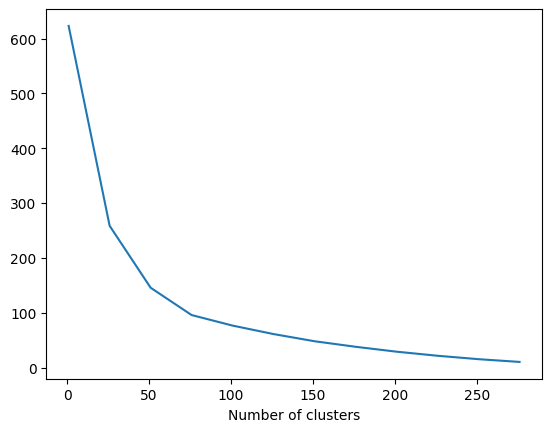

In [106]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [107]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=100,      # Maximum number of iterations for the algorithm
    n_init=10,         # Number of times the algorithm will run with different centroid seeds
    random_state=42    # For reproducibility
)
kmeans.fit(X_lsa)


KMeans(max_iter=100, n_clusters=50, n_init=10, random_state=42)

In [108]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
artt = df.drop_duplicates(subset='article_id')

article_cluster_map = dict(zip(artt['article_id'], kmeans.labels_)) # Map article_id to cluster label

df['title_cluster'] = df['article_id'].map(article_cluster_map)


# Now df will have a new column 'title_cluster' with the KMeans cluster labels
print(df[['article_id', 'title_cluster']].head())



   article_id  title_cluster
0        1430             45
1        1314             42
2        1429             28
3        1338             16
4        1276             25


In [109]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 11],
       [ 1, 23],
       [ 2, 23],
       [ 3,  4],
       [ 4, 68],
       [ 5, 48],
       [ 6, 20],
       [ 7, 19],
       [ 8, 13],
       [ 9,  9],
       [10, 16],
       [11, 29],
       [12, 18],
       [13, 17],
       [14,  8],
       [15,  8],
       [16, 14],
       [17, 14],
       [18, 28],
       [19,  8],
       [20, 20],
       [21,  9],
       [22, 28],
       [23,  8],
       [24,  7],
       [25, 12],
       [26, 10],
       [27, 12],
       [28, 22],
       [29,  8],
       [30,  8],
       [31, 11],
       [32,  9],
       [33,  7],
       [34,  5],
       [35, 10],
       [36, 10],
       [37, 11],
       [38,  7],
       [39,  9],
       [40, 10],
       [41, 28],
       [42,  8],
       [43,  8],
       [44,  5],
       [45, 12],
       [46,  5],
       [47,  3],
       [48,  7],
       [49,  7]])

In [110]:
import re

def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [111]:
def create_article_content_dataframe(df=df, df_content=df):
    '''
    INPUT:
    df - pandas dataframe describe user interaction with th articles
    df_content - pandas dataframe describe articles on the platforme
    OUTPUT:
    df_total - pandas dataframe contains all articles in the platforme
    article_content -  pandas dataframe describe the content of each
                       article on the plateforme

    Description:
    Return a pandas dataframe contains all the articles in the platforme
    with thier titles and a pandas dataframe describes the content of each
    article base on the article title.
    '''

    # Get a dataframe of the full articles
    df_1 = df[['article_id', 'title']]
    df_2 = pd.DataFrame({'article_id': df.article_id.values,
                         'title':df.title })
    df_total = pd.concat([df_1, df_2], ignore_index=True)
    df_total.drop_duplicates(subset=['article_id'], inplace=True)
    df_total.sort_values(by='article_id', inplace=True)
    df_total.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer()
    df_vec = pd.DataFrame(vectorizer.fit_transform(
                          df_total.title.values).toarray(),
                          columns=[*vectorizer.vocabulary_])

    # concat  df_total and df_vec
    df_articles = pd.concat([df_total, df_vec], axis=1)

    return df_total, df_articles


df_total, df_articles = create_article_content_dataframe()

In [112]:

df_total.head()

,article_id,title
0,0,detect malfunctioning iot sensors with streami...
1,2,"this week in data science (april 18, 2017)"
2,4,analyze ny restaurant data using spark in dsx
3,8,data science bowl 2017
4,9,3992 using apache spark to predict attack v...


In [180]:
df.head()

,article_id,title,email,user_id,title_cluster
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1,45
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2,42
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3,28
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4,16
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5,25


In [184]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) DataFrame containing article data with a 'cluster_labels' column
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Find the cluster that the article belongs to
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    
    # Find all articles in the same cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].tolist()
    
    # Remove the input article_id from the list
    articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [129]:
article_similarity = get_similar_articles()
article_similarity

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.000000,0.000000,0.000000,0.000000,0.149928,0.036866,0.126721,0.0,0.000000,...,0.0,0.042557,0.000000,0.000000,0.054127,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,1.000000,0.072723,0.306586,0.000000,0.021530,0.036936,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.051781,0.036724,0.016957,0.000000,0.000000,0.034757
4,0.0,0.072723,1.000000,0.035224,0.116854,0.087961,0.034728,0.135094,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.048685,0.034529,0.015943,0.000000,0.000000,0.032679
8,0.0,0.306586,0.035224,1.000000,0.000000,0.029503,0.050615,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.050324,0.023237,0.000000,0.000000,0.000000
9,0.0,0.000000,0.116854,0.000000,1.000000,0.050306,0.000000,0.165201,0.0,0.000000,...,0.0,0.000000,0.061204,0.000000,0.098850,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.0,0.036724,0.034529,0.050324,0.000000,0.028921,0.049616,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.386122,0.000000,0.000000,0.000000
1441,0.0,0.016957,0.015943,0.023237,0.000000,0.057017,0.022910,0.000000,0.0,0.030854,...,0.0,0.000000,0.000000,0.038219,0.000000,0.386122,1.000000,0.000000,0.000000,0.038534
1442,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.107329,0.066994


In [186]:
def make_content_recs(article_id, n, df=df_articles):
    """
    Returns the n most similar articles to a given article_id.

    INPUT:
    article_id - (int) the ID of the article for which recommendations are being made
    n - (int) the number of similar articles to recommend
    df - (pandas dataframe) the dataset containing articles and related information

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids 
    n_ranked_article_names - (list) a list of article names
    """
    # Get similar articles based on the similarity matrix
    similar_articles = article_similarity.loc[article_id]
    similar_articles = similar_articles[similar_articles > 0]  # Filter out non-similar articles
    similar_articles.sort_values(ascending=False, inplace=True)

    # Get the top n similar articles (excluding the input article)
    top_articles = similar_articles.index[similar_articles.index != article_id][:n]

    # Convert to regular Python integers
    recs = [int(article) for article in top_articles]

    # Get article names
    rec_names = get_article_names(recs, df=df)

    return recs, rec_names
        

In [189]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[237, 48, 1025, 416, 821, 508, 644, 986, 975, 593]
[title    deep learning with data science experience
title                                           0.0
Name: 108, dtype: object, title    data science experience documentation
title                                      0.0
Name: 23, dtype: object, title    data tidying in data science experience
title                                        0.0
Name: 426, dtype: object, title    using the maker palette in the ibm data scienc...
title                                                  0.0
Name: 188, dtype: object, title    using rstudio in ibm data science experience
title                                             0.0
Name: 343, dtype: object, title    data science in the cloud
title                          0.0
Name: 228, dtype: object, title    h2o with ibm's data science experience (dsx)
title                                             0.0
Name: 273, dtype: object, title    r for data science
title                   0.0
Name: 411, 

In [188]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

A content-based recommendation system suggests articles to users based on the similarity of article content rather than user interactions alone. The main idea is that if a user has read a particular article, they are likely to be interested in similar articles.

Area of fine tuning recommendations:
- We could integrate collaborative filtering (user-user similarity) with content-based filtering (text similarity) to improve recommendation diversity.
- Instead of only tracking interactions (clicks), incorporate time spent on an article, articles that were read longer may indicate deeper interest.

Other text might be useful for recommendations:
- Article summary or full text could improve recommendation quality.
- Tags, categories, or other descriptive metadata could provide additional context about the articles and potentially improve recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [190]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [191]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

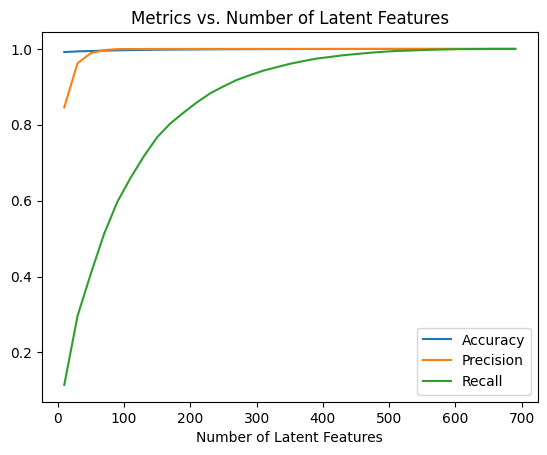

In [192]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Based on this plot, I would recommend selecting around 100-200 latent features as a good balance between precision and recall, ensuring we get useful recommendations without overfitting

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [193]:
from sklearn.metrics.pairwise import cosine_similarity

def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are similar to the given article_id
                  If include_similarity is True, returns a list of lists with [[similar_article_id, similarity], ...]
    
    Description:
    Returns a list of the article ids similar to the given article_id using SVD factorization.
    """
    # Find the index of the article_id in the user_item columns
    article_idx = user_item.columns.get_loc(article_id)
    
    # Transpose vt to get a 714 x k matrix (k = number of latent features)
    vt_transposed = vt.T
    
    # Calculate cosine similarity between the given article and all other articles
    cos_sim = cosine_similarity(vt_transposed[article_idx].reshape(1, -1), vt_transposed).flatten()
    
    # Get the indices of the most similar articles (excluding the input article)
    similar_article_indices = cos_sim.argsort()[::-1]  # Sort in descending order
    similar_article_indices = similar_article_indices[similar_article_indices != article_idx]  # Exclude the input article
    
    # Get the article_ids corresponding to the similar article indices
    similar_article_ids = user_item.columns[similar_article_indices].tolist()
    
    if include_similarity:
        # Return a list of lists with [[similar_article_id, similarity], ...]
        similar_articles_with_scores = [[similar_article_ids[i], cos_sim[similar_article_indices[i]]] for i in range(len(similar_article_ids))]
        return similar_articles_with_scores
    else:
        # Return only the list of similar article_ids
        return similar_article_ids

In [194]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [195]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [196]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [197]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [198]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

- the recommendation based on similarity using TF-IDF (Content-Based Filterting) is good that helps group of articles to share same properties, but it didn't account for user interaction such as reading history.
  Pros : Recommend based on similarity, even for new user.
  Cons : Don't personalize based on user prefrence.
  Best Usecase => User with no history (solve the cold start problem)

- the recommendation based on Collaborative Filtering (User interacted with data and recomment based on the interaction)
    Cons: Struggle with new users (Cold Start problem)
    Best Usecase => Users with alot of history

a method by which you could test how well your recommendation engine is working in practice.

We can use nline Evaluation: A/B Testing:

Control Group (A): Users see a random selection of articles.

Test Group (B): Users see recommendations from the model.

Compare engagement metrics like:
Click-through rate (CTR): % of recommended articles clicked.

If users in Group B interact more with recommendations, it shows the engine is effective!

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

FileNotFoundError: [Errno 2] No such file or directory: 'python'